In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

# Import LNN
from ncps.tf import CfC
from ncps.wirings import AutoNCP
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, RepeatVector
from tensorflow.keras import mixed_precision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Config GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError: pass

WINDOW_SIZE = 30
BATCH_SIZE = 64
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset'
SCALER_PATH = 'scaler.joblib'
WEIGHTS_PATH = 'lnn_autoencoder_best.weights.h5'

# LNN Params
RECURRENT_UNITS = 128
BOTTLENECK_SIZE = 64

print("Configurazione Kinematic Test completata.")

Configurazione Kinematic Test completata.


In [2]:
def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


In [3]:
scaler = joblib.load(SCALER_PATH)
all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]

print("Ricostruzione LNN")
wiring = AutoNCP(RECURRENT_UNITS, output_size=BOTTLENECK_SIZE)
inputs = Input(shape=(WINDOW_SIZE, 4))
lnn_encoder = CfC(wiring, return_sequences=False, mixed_memory=True)(inputs)
repeat_vector = RepeatVector(WINDOW_SIZE)(lnn_encoder)
lnn_decoder = CfC(wiring, return_sequences=True, mixed_memory=True)(repeat_vector)
output = TimeDistributed(Dense(4))(lnn_decoder)
model = Model(inputs, output)

model.load_weights(WEIGHTS_PATH)
print("Pesi LNN caricati.")
test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

Ricostruzione LNN


I0000 00:00:1764184322.952152   98339 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Pesi LNN caricati.


In [4]:
def apply_kinematic_attack(batch_clean, attack_start_idx=15, shift_magnitude=2.0):

    #batch_clean: Batch di dati normalizzati
    #attack_start_idx: A quale step inizia l'attacco (15 è metà finestra)
    #shift_magnitude: Di quanto spostare (in deviazioni standard)
    
    batch_attacked = batch_clean.copy()
    
    # Aggiungiamo un offset costante (simuliamo un salto istantaneo)
    # Questo crea un "gradino" impossibile nella posizione
    batch_attacked[:, attack_start_idx:, 0] += shift_magnitude # Sposta Lat
    batch_attacked[:, attack_start_idx:, 1] += shift_magnitude # Sposta Lon
    
    # non modifichiamo SOG e COG (indici 2 e 3). 
    # È qui l'incoerenza perchè la posizione cambia, ma la velocità non lo giustifica.
    
    return batch_attacked
print("Funzione di attacco definita.")

Funzione di attacco definita.


In [5]:
# Creiamo il dataset misto
X_test_mixed = []
y_true = [] # 0 = Normale, 1 = Attacco

# Prendiamo NUM_BATCHES batch dal generatore
NUM_BATCHES = 10000

for _ in range(NUM_BATCHES):
    #Prendi dati puliti
    clean_batch, _ = next(test_gen)
    
    #Crea la versione attaccata
    attacked_batch = apply_kinematic_attack(clean_batch, shift_magnitude=3.0) # Attacco forte
    
    #Aggiungi alla lista
    #Aggiungiamo metà puliti
    half = len(clean_batch) // 2
    X_test_mixed.append(clean_batch[:half])
    y_true.extend([0] * half) # Etichetta 0
    
    #Aggiungiamo metà attaccati
    X_test_mixed.append(attacked_batch[half:])
    y_true.extend([1] * (len(clean_batch) - half)) #Etichetta 1

# Concateniamo tutto in un unico array numpy
X_test_mixed = np.concatenate(X_test_mixed)
y_true = np.array(y_true)

print(f"Dataset creato: {X_test_mixed.shape}")
print(f"Campioni Normali: {np.sum(y_true == 0)}")
print(f"Campioni Attaccati: {np.sum(y_true == 1)}")

Dataset creato: (640000, 30, 4)
Campioni Normali: 320000
Campioni Attaccati: 320000


In [6]:
print("Esecuzione predizioni sul dataset misto...")
reconstructions = model.predict(X_test_mixed, verbose=1)

# Calcoliamo l'errore MAE 
mae_per_sample = np.mean(np.abs(X_test_mixed - reconstructions), axis=(1, 2))

print(f"Calcolo errori completato")

Esecuzione predizioni sul dataset misto...
20000/20000 [==============================] - 311s 16ms/step
Calcolo errori completato


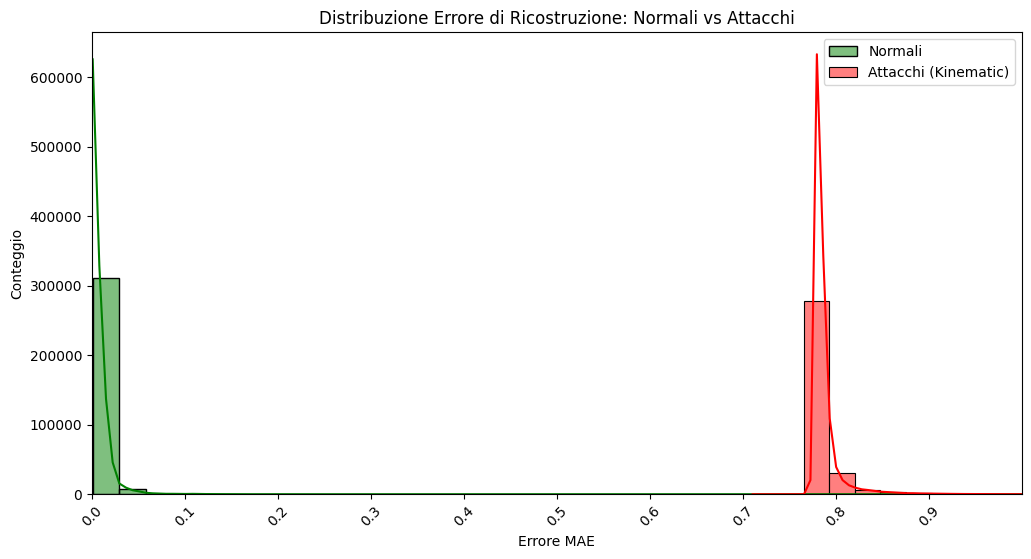

In [9]:
plt.figure(figsize=(12, 6))

# Istogramma Normali (Verde)
sns.histplot(mae_per_sample[y_true == 0], color='green', label='Normali', kde=True, bins=50, alpha=0.5)

# Istogramma Attacchi (Rosso)
sns.histplot(mae_per_sample[y_true == 1], color='red', label='Attacchi (Kinematic)', kde=True, bins=50, alpha=0.5)

plt.xlim(0, 1.0)
plt.xticks(np.arange(0, 1.0, 0.1), rotation=45)

plt.title("Distribuzione Errore di Ricostruzione: Normali vs Attacchi")
plt.xlabel("Errore MAE")
plt.ylabel("Conteggio")
plt.legend()
plt.show()

Soglia rilevamento calcolata (Mean + 3*Std): 0.0505

--- RISULTATI CLASSIFICAZIONE ---
Accuracy:  0.9952
Precision: 0.9906
Recall:    1.0000
F1-Score:  0.9953


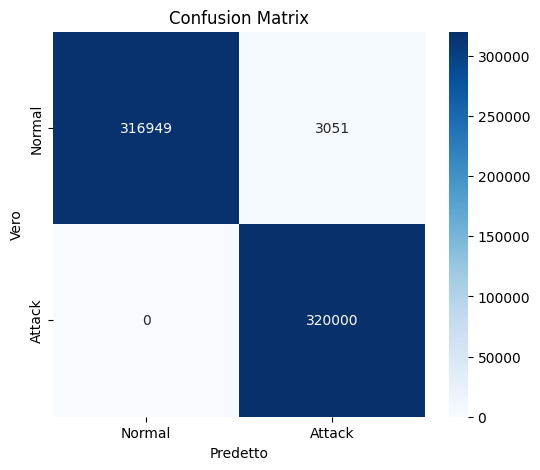

In [10]:
# Definiamo la soglia (Threshold)
errori_normali = mae_per_sample[y_true == 0]
THRESHOLD = np.mean(errori_normali) + 3 * np.std(errori_normali)
print(f"Soglia rilevamento calcolata (Mean + 3*Std): {THRESHOLD:.4f}")

# Classificazione --> Se errore > soglia -> È un attacco (1)
y_pred = (mae_per_sample > THRESHOLD).astype(int)

# Metriche
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n--- RISULTATI CLASSIFICAZIONE ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Matrice di Confusione
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix")
plt.ylabel("Vero")
plt.xlabel("Predetto")
plt.show()

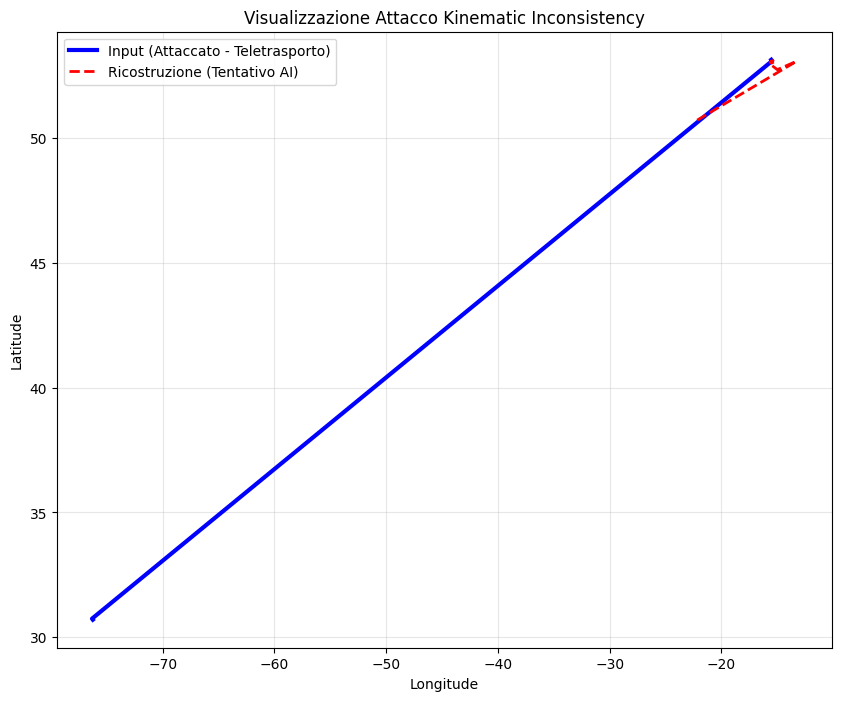

In [20]:
# Troviamo un esempio di attacco rilevato
attack_indices = np.where(y_true == 1)[0]
idx = attack_indices[0] # Il primo attacco

real_input = X_test_mixed[idx] # Questo è quello corrotto
reconstructed = reconstructions[idx] # Questo è quello che la rete ha provato a fare

# Denormalizziamo per il plot 2D
real_phys = scaler.inverse_transform(real_input)
recon_phys = scaler.inverse_transform(reconstructed)

plt.figure(figsize=(10, 8))
plt.plot(real_phys[:, 1], real_phys[:, 0], 'b-', label='Input (Attaccato - Teletrasporto)', linewidth=3)
plt.plot(recon_phys[:, 1], recon_phys[:, 0], 'r--', label='Ricostruzione (Tentativo AI)', linewidth=2)
plt.title("Visualizzazione Attacco Kinematic Inconsistency")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()